In [2]:
import random
from typing import Tuple

import optax
import jax.numpy as jnp
import jax
import numpy as np

In [58]:
l_x_t = np.load('subtraj.npy')
diff_matrix_inv_ = np.load('d_inv.npy')

In [57]:
l_x_t_t = np.transpose(l_x_t,(0,2,1))
l_x_t_t.shape

(296, 30, 40)

In [34]:
l_x_t_t = np.transpose(l_x_t,(0,2,1))
monomials = jax.vmap(f)(l_x_t_t)
%timeit monomials = jax.vmap(f)(l_x_t_t)
monomials.shape, l_x_t_t.shape

NameError: name 'f' is not defined

In [42]:
import jax
import jax.numpy as jnp
import haiku as hk

class MonomialLayer(hk.Module):
    def __init__(self, degree, n):
        super().__init__()
        self.degree = degree
        self.n = n
    
    def __call__(self, x):
        print(x.shape)
        monomials = [jnp.power(x[:, :, 0], 0)] 
        for d in range(1, self.degree + 1):
            for i in range(self.n):
                monomials.append(jnp.power(x[:, :, i], d))
            for i in range(self.n):
                for j in range(i + 1, self.n):
                    for k in range(d-1, 0, -1):
                        monomials.append(jnp.power(x[:, :, i], k) * jnp.power(x[:, :, j], d-k))
        return jnp.stack(monomials, axis=-1)

In [ ]:
v= np.zeros((10,3))
v[1,0] = -10
v[2,0] = 10
v[1,1] = 28
v[2,1] = -1
v[8,1] = -1.
v[3,2] =  -8. / 3
v[7,2] =  1.

class PolynomialRegressor(hk.Module):
    def __init__(self, dim_system):
        super().__init__()
        self.monomials = MonomialLayer(2,dim_system)
        self.lay1 = hk.Linear(dim_system, w_init=hk.initializers.RandomNormal(.01), with_bias=False)

    def __call__(self, x):
        y = self.monomials(x)
        y = self.lay1(y)
        return y
    
@jax.jit
def forward_poly(x):
  model = PolynomialRegressor(40)
  return model(x)

forward_po = hk.transform(forward_poly)


l_x_t_t = np.transpose(l_x_t,(0,2,1))
x = l_x_t_t
key = hk.PRNGSequence(42)
params = forward_po.init(next(key), x)

y = forward_po.apply(params, None, x)

def wrap_poly(params):
  def f(x):
    return forward_po.apply(params, None, x)
  return f

%timeit y = forward_po.apply(params, None, x)
f_poly = jax.jit(wrap_poly(params))
y = f_poly(x)
%timeit y = f_poly(x)

def ground_truth(x):
	ans = np.zeros(x.shape[0])
	s = 10.
	r = 28.
	b = 8. / 3.
	ans[0] = s * (x[1]-x[0])
	ans[1] = x[0] * (r - x[2]) - x[1]
	ans[2] = x[0] * x[1] - b* x[2]
	return ans

In [49]:
v= np.zeros((10,3))
v[1,0] = -10
v[2,0] = 10
v[1,1] = 28
v[2,1] = -1
v[8,1] = -1.
v[3,2] =  -8. / 3
v[7,2] =  1.

class PolynomialRegressor(hk.Module):
    def __init__(self, dim_system):
        super().__init__()
        self.monomials = MonomialLayer(2,dim_system)
        #self.lay1 = hk.Linear(3, w_init=hk.initializers.Constant(v), with_bias=False)
        self.lay1 = hk.Linear(dim_system, w_init=hk.initializers.RandomNormal(.01), with_bias=False)

    def __call__(self, x):
        y = self.monomials(x)
        y = self.lay1(y)
        return y
    
@jax.jit
def forward_poly(x):
  model = PolynomialRegressor(40)
  return model(x)

forward_po = hk.transform(forward_poly)


l_x_t_t = np.zeros((1,1,80))
x = l_x_t_t
key = hk.PRNGSequence(42)
params = forward_po.init(next(key), x)

y = forward_po.apply(params, None, x)

def wrap_poly(params):
  def f(x):
    return forward_po.apply(params, None, x)
  return f


(1, 1, 80)


{'polynomial_regressor/~/linear': {'w': Traced<ShapedArray(float32[861,40])>with<DynamicJaxprTrace(level=1/0)>}}

In [9]:
class NNetRegressor(hk.Module):
    def __init__(self):
        super().__init__()
        self.lay2 = hk.Sequential([hk.Linear(300, w_init=hk.initializers.RandomNormal(.01)), jax.nn.relu])
        self.lay3 = hk.Sequential([hk.Linear(300, w_init=hk.initializers.RandomNormal(.01)), jax.nn.relu])
        self.lay1 = hk.Linear(3, w_init=hk.initializers.RandomNormal(.001), with_bias=False)

    def __call__(self, x):
        y = self.lay2(x)
        y = jax.nn.relu(self.lay3(y) + y)
        y = jax.nn.relu(self.lay3(y) + y)
        y = self.lay1(y)
        return y

array([1.000183 , 0.9864449, 1.0025252], dtype=float32)

In [219]:
def lorenz(t,x):
    return ground_truth(x)

<function __main__.ground_truth(x)>

In [242]:
from scipy.integrate import solve_ivp

def lorenz(t,x):
    return ground_truth(x)

integrator_keywords = {}
integrator_keywords['rtol'] = 1e-7
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-7
t_train_span = (0, 40)
dt = .005
x0_train = (1,1.5,4)
t_measures = np.arange(t_train_span[0], t_train_span[1], dt)
X_ref =    solve_ivp(lorenz, t_train_span, x0_train, t_eval=t_measures, **integrator_keywords).y

@jax.jit
def learnt(t,x):
    return network.apply(state.params, x[np.newaxis, np.newaxis,:])
X_learnt = solve_ivp(learnt, t_train_span, x0_train, t_eval=t_measures, **integrator_keywords).y

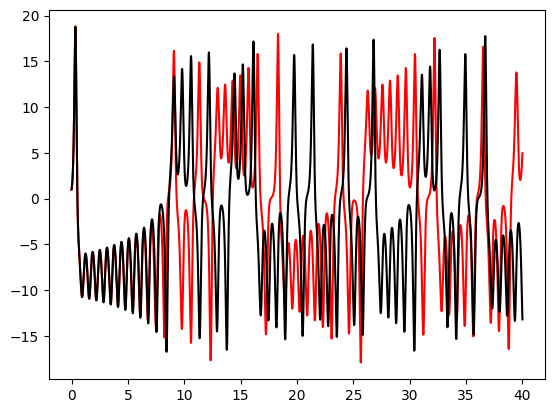

In [293]:
plt.plot(t_measures,X_learnt[0,:], c='red')
plt.plot(t_measures,X_ref[0,:], c='black')

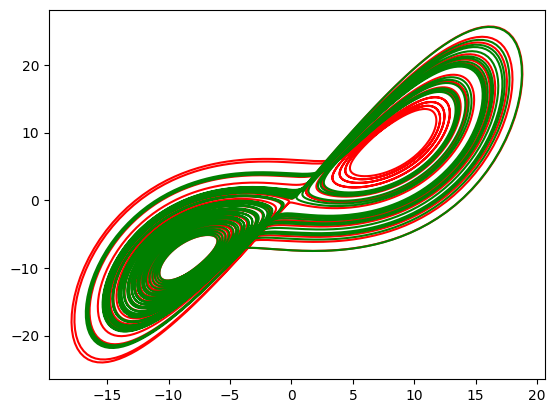

In [244]:
plt.plot(X_learnt[0,:], X_learnt[1,:], c='red')
plt.plot(X_ref[0,:], X_ref[1,:], c='green')

In [56]:
l_x_t_t_h.shape, l_x_t.shape

((791, 30, 2), (296, 40, 30))

In [58]:
currBest_value

array(0.0767343, dtype=float32)

In [22]:
output currBest_sol['polynomial_regressor/~/linear']['w']* (abs(currBest_sol['polynomial_regressor/~/linear']['w'])>1e-2)

Array([[-9.9970350e+00,  2.7971287e+01,  1.8158158e-02],
       [ 9.9959545e+00, -9.9795753e-01,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00, -2.6685927e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  1.0019039e+00],
       [ 0.0000000e+00, -9.9940521e-01,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32)

In [23]:
l_x_t.shape, l_x_t_t.shape

((196, 3, 30), (196, 30, 3))

Partial Observations

In [13]:
from typing import Optional

class Identity(hk.Module):
  def __init__(self, input_size, lgr_degree, hidden_dim):
    super().__init__('id')
    self.input_size = input_size
    self.lgr_degree = lgr_degree
    self.hidden_dim = hidden_dim
  
  def __call__(self,x):
    if self.hidden_dim>0:
      x_h = hk.get_parameter("x_hidden", shape=[self.input_size,  self.lgr_degree, self.hidden_dim], init=hk.initializers.RandomNormal(.01))
    return x

In [97]:

l_x_t_t = np.transpose(l_x_t, (0,2,1))
l_x_t.shape


(399, 3, 30)

In [ ]:
from typing import Iterator, NamedTuple
import time

from typing import Optional

class Identity(hk.Module):
  def __init__(self, input_size, lgr_degree, hidden_dim):
    super().__init__('id')
    self.input_size = input_size
    self.lgr_degree = lgr_degree
    self.hidden_dim = hidden_dim
  
  def __call__(self,x):
    if self.hidden_dim>0:
      x_h = hk.get_parameter("x_hidden", shape=[self.input_size,  self.lgr_degree, self.hidden_dim], init=hk.initializers.RandomNormal(.01))
    return x

class TrainingState(NamedTuple):
  params: hk.Params
  opt_state_hidden: optax.OptState
  opt_state_joint: optax.OptState

class Batch(NamedTuple):
  x: np.ndarray  # [a, K, N]
  indices: np.ndarray # [a]
  dim_hidden = 1

class BatchIterator:
  def __init__(self, x: np.ndarray, 
    shuffle: bool,
    batch_size: int):
    self.x = x
    self.shuffle = shuffle
    self.batch_size = batch_size
    self.curr = 0

  def __iter__(self, ):
    self.curr = 0
    return self

  def __next__(self):
    if self.shuffle:
      indices = np.random.choice(x.shape[0], size=self.batch_size, replace=True)
      return Batch(x=self.x[indices,:,:], indices=indices)
    else:
      a = self.curr
      b = min(self.curr + self.batch_size, x.shape[0])
      if a==b:
        raise StopIteration
      else:
        self.curr = b
        return Batch(x=self.x[a:b,:,:], indices=np.arange(a, b+1))

def dyn_poly(x: jax.Array) -> jax.Array:
    model = PolynomialRegressor(3)
    identity = Identity(399,30,1)
    #model = NNetRegressor()
    return model(identity(x))

network = hk.without_apply_rng(hk.transform(dyn_poly))
optimizer_hidden = optax.adam(1e-3)
optimizer_joint = optax.adam(1e-3)

network_forward = jax.jit(network.apply)

@jax.jit
def loss(trainable_params: hk.Params, non_trainable_params: hk.Params, batch: Batch) -> jax.Array:
    x= batch.x
    indices = batch.indices
    dim_hidden = batch.dim_hidden

    params = hk.data_structures.merge(trainable_params, non_trainable_params)
    if dim_hidden>0:
      x_hidden = jax.numpy.take(params['id']['x_hidden'], indices, axis=0)
      x = jnp.concatenate([x, x_hidden], axis=-1)
    
    f_pred = network_forward(params, x[:,1:,:])

    @jax.jit
    def interval_loss(x_int, f_x_int):
      y= jnp.dot(diff_matrix_inv_[1:, 1:], f_x_int)+ x_int[0, :][jnp.newaxis, :] - x_int[1:, :]
      return 1/(y.shape[0]) * jnp.linalg.norm(y)**2

    a = jnp.mean(jax.vmap(interval_loss, in_axes=[0,0])(x, f_pred))
    return a

@jax.jit
def evaluate(params: hk.Params, batch: Batch) -> jax.Array:
  return loss(params, {}, batch)

grad_loss_jitted = jax.jit(jax.grad(loss))
optimizer_hidden_update = jax.jit(optimizer_hidden.update)
@jax.jit
def update_hidden(state: TrainingState, batch: Batch) -> TrainingState:
  trainable, non_trainable = hk.data_structures.partition(
    lambda m, n, p: 'x_hidden' in n, state.params)
  grads = grad_loss_jitted(trainable, non_trainable , batch)
  updates, opt_state_hidden = optimizer_hidden_update(grads, state.opt_state_hidden)
  trainable_updated = optax.apply_updates(trainable, updates)

  params = hk.data_structures.merge(trainable_updated, non_trainable)
  return TrainingState(params=params, opt_state_joint=state.opt_state_joint, opt_state_hidden=opt_state_hidden)

optimizer_joint_update = jax.jit(optimizer_joint.update)
@jax.jit
def update_jointly(state: TrainingState, batch: Batch) -> TrainingState:
  trainable, non_trainable = hk.data_structures.partition( lambda m, n, p: True, state.params)
  grads = grad_loss_jitted(trainable, non_trainable, batch)
  updates, opt_state_joint = optimizer_joint_update(grads, state.opt_state_joint)
  params = optax.apply_updates(trainable, updates)
  return TrainingState(params=params, opt_state_joint=opt_state_joint, opt_state_hidden=state.opt_state_hidden)


# Initialise network and optimiser; note we draw an input to get shapes.
initial_params = network.init(
    jax.random.PRNGKey(seed=0), l_x_t_t[:,:,: ])
initial_opt_state_j = optimizer_joint.init(initial_params)

trainable, non_trainable = hk.data_structures.partition(lambda m, n, p: 'x_hidden' in n, initial_params)
initial_opt_state_h = optimizer_hidden.init(trainable)
state = TrainingState(params=initial_params, opt_state_hidden=initial_opt_state_h, opt_state_joint=initial_opt_state_j)

l_x_t_t = np.transpose(l_x_t, (0, 2, 1))
l_x_t_t_h = l_x_t_t[:,:,:2] + 0. # hide the last dimension
print(l_x_t.shape, l_x_t_t.shape, l_x_t_t_h.shape, )
l = []
for epoch in zip([50, 100, 200], [30001, 15001, 25001], range(3)):
  start = time.time_ns()
  itDS = iter(BatchIterator(l_x_t_t_h, True, epoch[0]))
  print("--->", next(itDS).x.shape)
  # Training & evaluation loop.
  for step in range(epoch[1]):
    if step % 100 == 0 :
      for i in range(50):
        state = update_hidden(state, Batch(x=l_x_t_t_h, indices=np.arange(0,l_x_t_t_h.shape[0])))
      loss_value = np.array(evaluate(state.params, Batch(x=l_x_t_t_h, indices=np.arange(0,l_x_t_t_h.shape[0]))))
      print(f"step: {step}, loss: {loss_value:.3f}", end='\r')
      l.append(loss_value)
    ds = next(itDS)
    for j in range(10):
      state = update_hidden(state, ds)
    for j in range(5):
      state = update_jointly(state, ds)

  for i in range(50):
    state = update_hidden(state, Batch(x=l_x_t_t_h, indices=np.arange(0,l_x_t_t_h.shape[0])))
  print(f"epoch {epoch[2]}: loss: {np.array(evaluate(state.params, Batch(x=l_x_t_t_h, indices=np.arange(0,l_x_t_t_h.shape[0])))):.3f} in {(time.time_ns() - start)*1e-9} (s)                 ")


In [ ]:
for epoch in zip([400, 500], [20001, 20001], range(3)):
  itDS = iter(BatchIterator(l_x_t_t_h, True, epoch[0]))
  # Training & evaluation loop.
  for step in range(epoch[1]):
    if step % 100 == 0 :
      for i in range(100):
        state = update_hidden(state, Batch(x=l_x_t_t_h, indices=np.arange(0,l_x_t_t_h.shape[0])))
      loss_value = np.array(evaluate(state.params, Batch(x=l_x_t_t_h, indices=np.arange(0,l_x_t_t_h.shape[0]))))
      print(f"step: {step}, loss: {loss_value:.5f}", end='\r')
      l.append(loss_value)
    ds = next(itDS)
    for j in range(5):
      state = update_hidden(state, ds)
    for j in range(5):
      state = update_jointly(state, ds)

  for i in range(100):
    state = update_hidden(state, Batch(x=l_x_t_t_h, indices=np.arange(0,l_x_t_t_h.shape[0])))
  print(f"epoch {epoch[2]}: loss: {np.array(evaluate(state.params, Batch(x=l_x_t_t_h, indices=np.arange(0,l_x_t_t_h.shape[0])))):.3f}                      ")
